In [77]:
import os
import pandas as pd
import numpy as np
import sqlalchemy
import sklearn
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

connection_string = os.getenv("LINODE_CONN_STRING")
connection_string = os.getenv("LINODE_CONN_STRING")
conn = sqlalchemy.create_engine(os.getenv("LINODE_CONN_STRING")).connect()

In [78]:
data = pd.read_sql("select * from sports_data.tourney_games_v6", conn)

In [79]:
data = data.replace(np.NaN, 0)

In [81]:
data['Win_Loss_Flag'] = data['Win_Loss'].apply(lambda x: 1 if x == 'W' else 0)

In [82]:
data.columns

Index(['date', 'season', 'team', 'opponent', 'Win_Loss',
       'regular_season_win_pct', 'opponent_regular_season_win_pct',
       'season_win_pct', 'opponent_season_win_pct', 'season_ppg',
       ...
       'opponent_vs_tourney_team_allowed_offensive_rebound_percent_std',
       'season_allowed_free_throw_rate',
       'opponent_season_allowed_free_throw_rate',
       'season_allowed_free_throw_rate_std',
       'opponent_season_allowed_free_throw_rate_std',
       'vs_tourney_team_allowed_free_throw_rate',
       'opponent_vs_tourney_team_allowed_free_throw_rate',
       'vs_tourney_team_allowed_free_throw_rate_std',
       'opponent_vs_tourney_team_allowed_free_throw_rate_std',
       'Win_Loss_Flag'],
      dtype='object', length=121)

In [83]:
predictor_cols = data.columns.to_list()

In [84]:
predictor_cols.remove('Win_Loss')
predictor_cols.remove('Win_Loss_Flag')
# 'date', 'season', 'team', 'opponent'
predictor_cols.remove('date')
predictor_cols.remove('season')
predictor_cols.remove('team')
predictor_cols.remove('opponent')

In [85]:
predictors = data[predictor_cols]
predictors_and_response = pd.concat([predictors, data['Win_Loss_Flag']], axis=1)

In [86]:
prediction_data = data[predictor_cols]
prediction_data_normalized = (prediction_data-prediction_data.mean())/prediction_data.std()

In [87]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(prediction_data_normalized, data['Win_Loss_Flag'])

In [88]:
linreg_no_val_predictions = clf.predict(prediction_data_normalized)

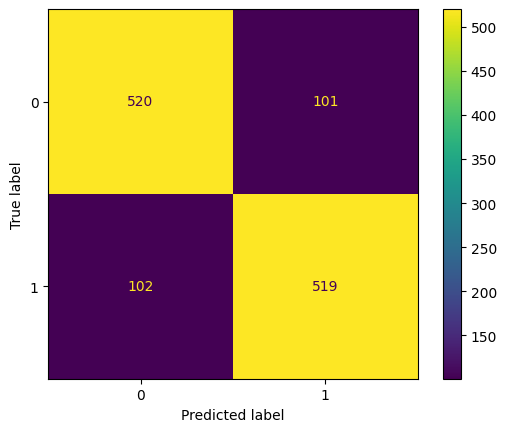

In [89]:
sklearn.metrics.ConfusionMatrixDisplay(sklearn.metrics.confusion_matrix(data['Win_Loss_Flag'], linreg_no_val_predictions)).plot()

In [90]:
def proper_cross_validation(clf, X, y, k=5):
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=k)
    confusion_matrices = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X_train, y_train)
        confusion_matrices.append(sklearn.metrics.confusion_matrix(y_test, clf.predict(X_test)))
    total_confusion_matrix = sum(confusion_matrices)
    return total_confusion_matrix

In [91]:
cms = proper_cross_validation(LogisticRegression(random_state=0), prediction_data_normalized, data['Win_Loss_Flag'])

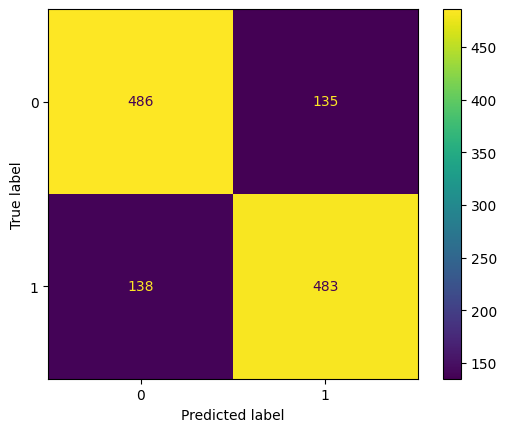

In [92]:
sklearn.metrics.ConfusionMatrixDisplay(cms).plot()

In [93]:
cms

array([[486, 135],
       [138, 483]], dtype=int64)

In [94]:
def expected_games_right(confusion_matrix):
    accuracy = (confusion_matrix[0,0] + confusion_matrix[1,1]) / confusion_matrix.sum()
    print(f"accuracy: {accuracy}")
    gr = 32.0 * accuracy
    gr = gr + (16 * (accuracy ** 2))
    gr = gr + (8 * (accuracy ** 3))
    gr = gr + (4 * (accuracy ** 4))
    gr = gr + (2 * (accuracy ** 5))
    gr = gr + (1 * (accuracy ** 6))
    return gr

In [95]:
def expected_score(confusion_matrix):
    accuracy = (confusion_matrix[0,0] + confusion_matrix[1,1]) / confusion_matrix.sum()
    gr = 32.0 * accuracy
    gr = gr + (32 * (accuracy ** 2))
    gr = gr + (32 * (accuracy ** 3))
    gr = gr + (32 * (accuracy ** 4))
    gr = gr + (32 * (accuracy ** 5))
    gr = gr + (32 * (accuracy ** 6))
    return gr

In [96]:
expected_games_right(cms)

accuracy: 0.7801932367149759


40.790400672073275

In [97]:
expected_score(cms)

87.96565780993437

accuracy: 0.7648953301127214
39.510916025242196
83.2597460516758


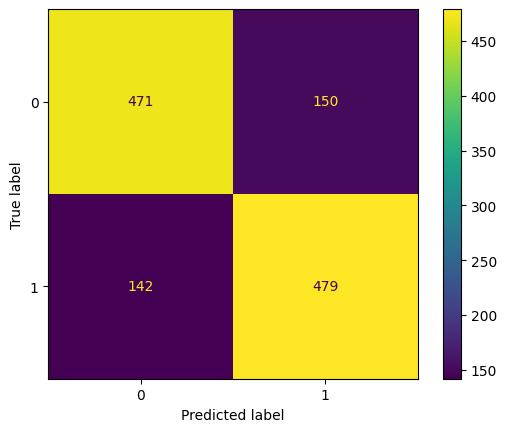

In [98]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=0, max_iter=3000)
cms = proper_cross_validation(clf, prediction_data_normalized, data['Win_Loss_Flag'])
sklearn.metrics.ConfusionMatrixDisplay(cms).plot()
print(expected_games_right(cms))
print(expected_score(cms))

accuracy: 0.7536231884057971
38.586902313324785
79.95030389822357


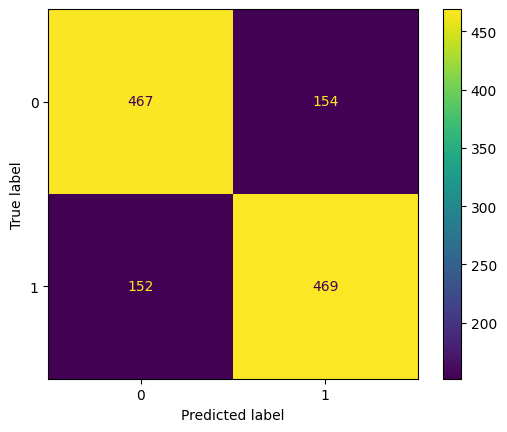

In [99]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=0, max_iter=3000, hidden_layer_sizes=[100, 100, 100])
cms = proper_cross_validation(clf, prediction_data_normalized, data['Win_Loss_Flag'])
sklearn.metrics.ConfusionMatrixDisplay(cms).plot()
print(expected_games_right(cms))
print(expected_score(cms))

accuracy: 0.7898550724637681
expected games correct: 41.61396777915384
expected score: 91.07047626890007


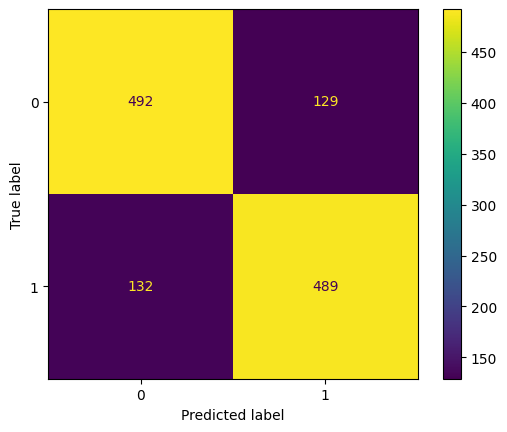

In [160]:
from sklearn.decomposition import PCA
pca = PCA(n_components=102)
pca.fit(prediction_data_normalized)
cms = proper_cross_validation(LogisticRegression(), pd.DataFrame(pca.transform(prediction_data_normalized)), data['Win_Loss_Flag'])
sklearn.metrics.ConfusionMatrixDisplay(cms).plot()
print(f"expected games correct: {expected_games_right(cms)}")
print(f"expected score: {expected_score(cms)}")

accuracy: 0.7761674718196457
expected games correct: 40.45080893378444
expected score: 86.70268539307449


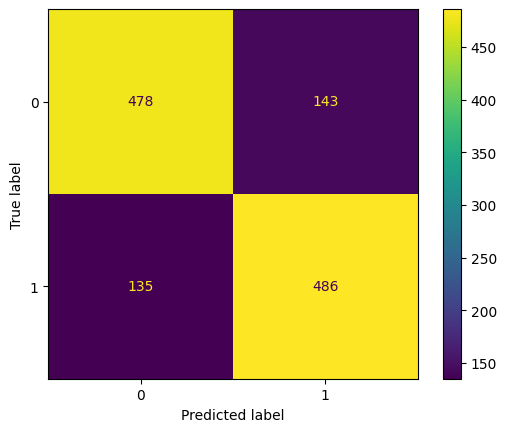

In [167]:
from sklearn.decomposition import PCA
pca = PCA(n_components=102)
pca.fit(prediction_data_normalized)
cms = proper_cross_validation(MLPClassifier(random_state=0, max_iter=30000, hidden_layer_sizes=[100,100]), pd.DataFrame(pca.transform(prediction_data_normalized)), data['Win_Loss_Flag'])
sklearn.metrics.ConfusionMatrixDisplay(cms).plot()
print(f"expected games correct: {expected_games_right(cms)}")
print(f"expected score: {expected_score(cms)}")

accuracy: 0.7536231884057971
expected games correct: 38.586902313324785
expected score: 79.95030389822357


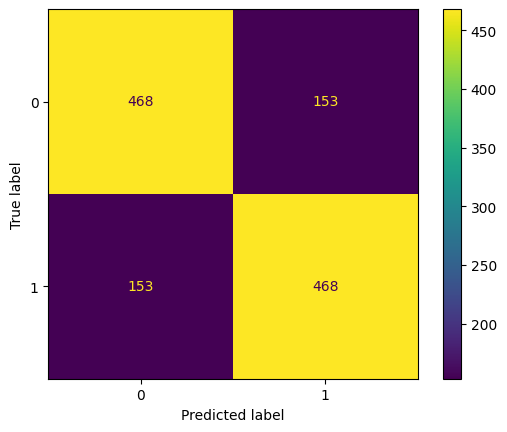

In [168]:
from sklearn import svm
from sklearn.decomposition import PCA
pca = PCA(n_components=102)
pca.fit(prediction_data_normalized)
cms = proper_cross_validation(svm.SVC(), pd.DataFrame(pca.transform(prediction_data_normalized)), data['Win_Loss_Flag'])
sklearn.metrics.ConfusionMatrixDisplay(cms).plot()
print(f"expected games correct: {expected_games_right(cms)}")
print(f"expected score: {expected_score(cms)}")